In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
from qiskit.algorithms.optimizers import SPSA
from qiskit import QuantumCircuit, Aer, transpile, QuantumRegister, ClassicalRegister
from math import pi, cos
import numpy as np
from qiskit.quantum_info import Statevector
import random
from problem_formulation import Node, Line , Grid , UCProblem
from QAOA_ansatz import create_hhl_circ
import cmath

In [2]:
def qft_dagger(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-pi/float(2**(j-m)), m, j)
        qc.h(j)
def disp_subsyst_statevector(sv,target_qubits):
    sv_list=get_subsyt_statevectors(sv, target_qubits)
    n=int(np.log2(len(sv)))
    no_change=True
    while no_change:
        no_el=len(sv_list)
        for i in range(no_el):
            i=no_el-1-i
            sv=sv_list[i]
            if sv[2]<0.003:
                sv_list.pop(i)
                no_change=False
                continue
            for j in range(i):
                if np.allclose(sv_list[j][1],sv[1]):
                    sv_list[j][0]+=sv[0]
                    sv_list[j][0]=list(set(sv_list[j][0]))
                    sv_list[j][2]+=sv[2]
                    sv_list.pop(i)
                    no_change=False
                    break
    sv_list.sort(key=lambda sv:sv[2])
    for sv in sv_list:
        print("When remaining qubits are in states", ",".join(["|"+(str(bin(ind))[2:]).zfill(n-len(target_qubits))+">" for ind in sv[0]]), " (probability=",sv[2],"),")
        print("the statevector of qubits", ",".join([str(q) for q in target_qubits]), "is")
        print(np.around(sv[1],3))
            
    
def get_subsyt_statevectors(sv, target_qubits):
    # sv=list(np.around(np.asarray(sv),3))
    sv=np.asarray(sv)
    n=int(np.log2(len(sv)))
    remaining_qubits=[i for i in range(n) if i not in target_qubits]
    sv_list=[]
    for i in range(2**len(remaining_qubits)):
        sv_el=[]
        active_remaining_qubits=[int(c) for c in str(bin(i))[2:][::-1]]
        index_=sum([on*2**q_num for on,q_num in zip(active_remaining_qubits,remaining_qubits)])
        for j in range(2**len(target_qubits)):
            active_target_qubits=[int(c) for c in str(bin(j))[2:][::-1]]
            index=index_+sum([on*2**q_num for on,q_num in zip(active_target_qubits,target_qubits)])
            sv_el+=[sv[index]]
        sv_el_norm=(sum([np.abs(el)**2 for el in sv_el]))**0.5
        sv_el=np.array(sv_el)
        first_el_phase=cmath.phase(sv_el[0])
        sv_el=sv_el*cmath.exp(-first_el_phase*1j)
        if sv_el_norm:
            sv_el=sv_el/sv_el_norm
        sv_list+=[[[i],sv_el,sv_el_norm**2]]

    return sv_list


In [3]:
#def real_amp_est(n, k, prep_circ, prec):
"""
Gets the real part of the k-th entry Re(v_k) of the statevector |v> = prep_circ|0>
and stores arccos(Re(v_k)) in basis encoding.

n (int): Number of qubits in prep_circ
k (int): Index of amplitude that we want to estimate
prep_circ (QuantumCircuit): Circuit that prepares the state we want to
                            conduct amplitude estimation on
prec (int): Number of qubits we want to use to store arccos(Re(v_k))
"""

node1=Node([20,20], 1, 1, 1, "gen1")
node2=Node([60,60], 1, 1, 1, "gen2")
node3=Node([-80,-80], 0,0,0, "load1")
line1=Line(node1,node2,80,80)
line2=Line(node1,node3,80,80)
line3=Line(node2,node3,20,20)

gen_node_count = 2
hhl_phase_qubit_count = 1

nodes = [node1,node2,node3]
lines = [line1,line2,line3]

real_powers = [node.real_power for node in nodes]
gen_nodesN = [node for node in nodes if node.real_power[0]>0]

node_count=len(real_powers)
tot_nodes=QuantumRegister(int(np.ceil(np.log2(node_count))), "tot_nodes")
n = gen_node_count+len(tot_nodes)+2+hhl_phase_qubit_count
k = 0

grid_timesteps = Grid(lines, nodes, [True for _ in nodes])

B=grid_timesteps.A
C, max_eigval=grid_timesteps.A_eig_bounds
min_eigval = C
timestep_count = 2
qadc_qubit_count = 2


In [4]:
state_prep_anc=QuantumRegister(1, "state_prep_anc")
hhl_phase_reg=QuantumRegister(hhl_phase_qubit_count, "hhl_phase_reg")
hhl_anc=QuantumRegister(1, "hhl_anc")
gen_nodes=[QuantumRegister(gen_node_count, "gen_nodes_at_t_"+str(i)) for i in range(timestep_count)]


In [5]:
t = 0
hhl_circ=create_hhl_circ([r[t] for r in real_powers],B,max_eigval,min_eigval,gen_nodes[0],tot_nodes,state_prep_anc,hhl_phase_reg,hhl_anc)
i = 1
j = 0
C_L = 80

Check if HHL circuit already exists
'HHL_[20, 60, -80]_[[220. -80. -80.]\n [-80. 100. -20.]\n [-80. -20. 100.]]_380.0_16.958724544651545_1_3'
Constructing HHL Circuit
Initial B: [[220. -80. -80.]
 [-80. 100. -20.]
 [-80. -20. 100.]]
Final B: [[ 3.6376336  -1.32277585 -1.32277585  0.        ]
 [-1.32277585  1.65346982 -0.33069396  0.        ]
 [-1.32277585 -0.33069396  1.65346982  0.        ]
 [ 0.          0.          0.          1.        ]]
B:
 [[ 3.6376336  -1.32277585 -1.32277585  0.        ]
 [-1.32277585  1.65346982 -0.33069396  0.        ]
 [-1.32277585 -0.33069396  1.65346982  0.        ]
 [ 0.          0.          0.          1.        ]]

The hamiltonian actually being simulated
by the approximated evolution operator:
 [[ 3.58317638-5.98045918e-16j -1.2452266 -4.25620262e-01j
  -1.29223379-1.42069818e-01j -0.06238202+2.81638116e-01j]
 [-1.2452266 +4.25620262e-01j  1.66372939+1.66533454e-16j
  -0.29003404+1.36228252e-01j -0.00874748-2.22455991e-01j]
 [-1.29223379+1.42069818e-0

In [6]:
st1 = Statevector.from_instruction(hhl_circ)
print("ST1:")
disp_subsyst_statevector(st1,[2,3])

ST1:
When remaining qubits are in states |10000>  (probability= 0.146045593307779 ),
the statevector of qubits 2,3 is
[ 0.418+0.j     0.69 -0.239j -0.509+0.022j  0.045+0.178j]
When remaining qubits are in states |00000>  (probability= 0.2172810435720275 ),
the statevector of qubits 2,3 is
[0.3  +0.j    0.495-0.172j 0.785-0.034j 0.032+0.128j]
When remaining qubits are in states |01000>,|11000>  (probability= 0.2520579785048009 ),
the statevector of qubits 2,3 is
[ 0.503-0.j    -0.555+0.24j   0.598-0.104j -0.027-0.112j]
When remaining qubits are in states |00100>,|10100>  (probability= 0.38461538461538125 ),
the statevector of qubits 2,3 is
[ 0.316+0.j  0.949-0.j  0.   -0.j -0.   +0.j]


In [7]:

#exp_k_abs_cos_circuit=construct_exp_k_abs_cos_circuit(qadc_qubit_count,4,abs(B[i][j])*C_L*(np.linalg.norm(np.array([r[t] for r in real_powers]))/min_eigval)*params_temp[0])

# Here we set the 0-th component of the statevector at the end of the hhl circuit to theta_i-theta_j

# Move theta_i to 0th component of statevector, also update j accordingly to track the position of theta_j
for k in range(len(tot_nodes)):
    if i%(2**(k+1))>=2**k:
        hhl_circ.x(tot_nodes[k])
        if j%(2**(k+1))>=2**k:
            j-=2**k
        else:
            j+=2**k

# Set k to be the position of the most significant 1 in binary expansion of j
k=len(tot_nodes)-1
while True:
    if j<2**k:
        k-=1
        continue
    break
# Move theta_j to 2**k-th component
for l in range(k):
    # If l-th digit of binary expansion of j is 1
    if j%(2**(l+1))>=2**l:
        hhl_circ.cx(tot_nodes[k],tot_nodes[l])
hhl_circ.h(k)
hhl_circ.x(k)

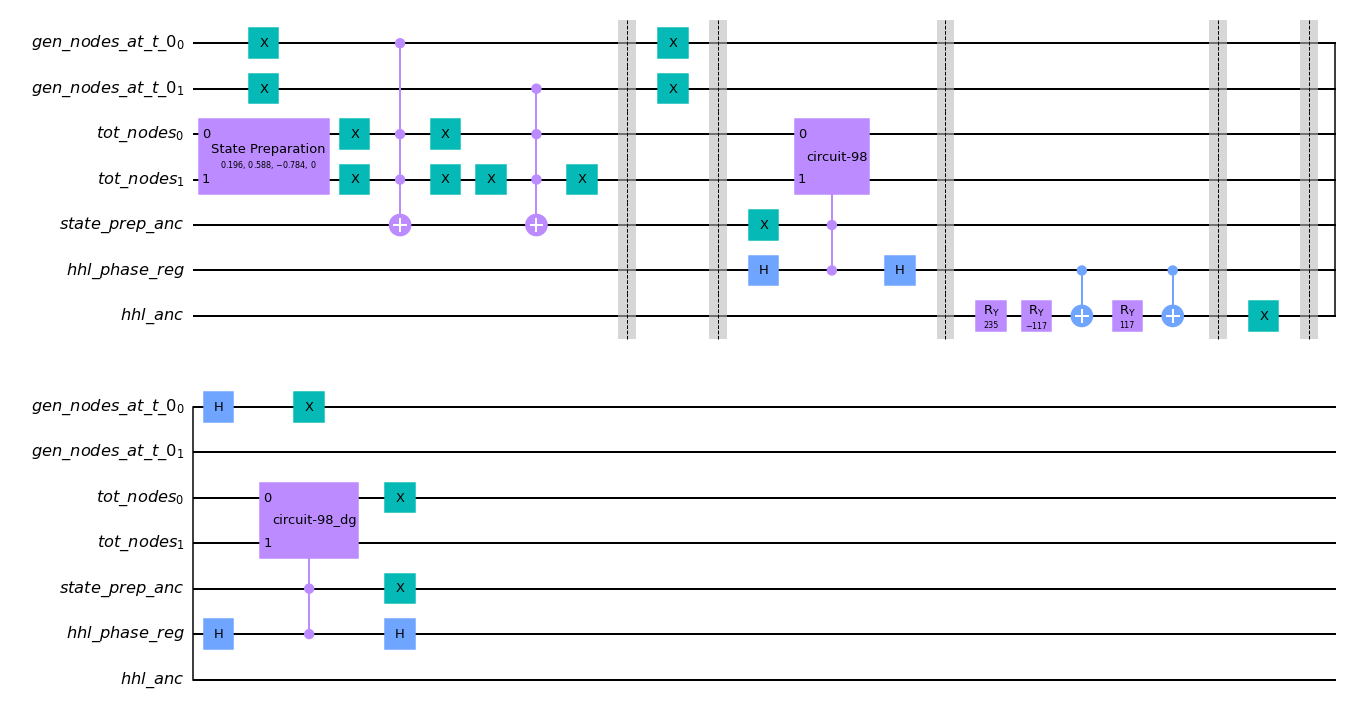

In [11]:
hhl_circ.draw('mpl')


In [8]:
st1 = Statevector.from_instruction(hhl_circ)
print("ST1:")
disp_subsyst_statevector(st1,[2,3])

ST1:
When remaining qubits are in states |10000>,|10001>  (probability= 0.14604559330777891 ),
the statevector of qubits 2,3 is
[ 0.73 +0.j     0.394+0.137j -0.016+0.183j -0.488-0.146j]
When remaining qubits are in states |00000>,|00001>  (probability= 0.2172810435720275 ),
the statevector of qubits 2,3 is
[ 0.524+0.j     0.283+0.098j -0.012+0.132j  0.753+0.225j]
When remaining qubits are in states |01000>,|11001>,|11000>,|01001>  (probability= 0.2520579785048009 ),
the statevector of qubits 2,3 is
[ 0.605+0.j    -0.461-0.2j   -0.019+0.113j -0.59 -0.142j]
When remaining qubits are in states |10101>,|00101>,|10100>,|00100>  (probability= 0.38461538461538125 ),
the statevector of qubits 2,3 is
[ 0.949+0.j  0.316+0.j -0.   +0.j  0.   -0.j]


In [9]:
prep_circ = hhl_circ
prec = qadc_qubit_count

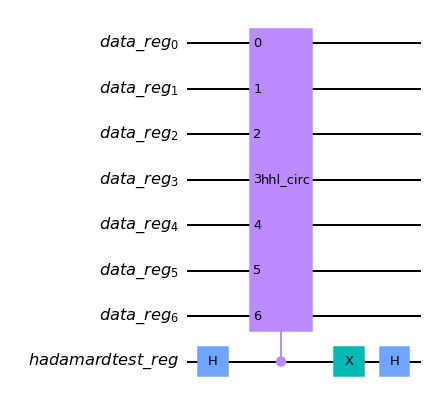

In [10]:

data_reg=QuantumRegister(n , name ="data_reg")
phase_reg=QuantumRegister(prec, name ="phase_reg")
hadamardtest_reg=QuantumRegister(1, name ="hadamardtest_reg")

qc=QuantumCircuit(phase_reg, data_reg, hadamardtest_reg)

# psiprep_circ is the circuit that prapares the |Psi> state from |0>
psiprep_circ=QuantumCircuit(data_reg, hadamardtest_reg)

# DataPrepGate is the gate of prep_circ which prepares the state we want to
# conduct amplitude estimation on

DataPrepGate=prep_circ.to_gate()
psiprep_circ.h(hadamardtest_reg)
psiprep_circ.append(DataPrepGate.control(1), list(hadamardtest_reg)+list(data_reg))
psiprep_circ.x(hadamardtest_reg)
k_temp=k
for i in range(n):
    if k%2:
        psiprep_circ.cx(hadamardtest_reg[0], data_reg[i])
    k=k//2
k=k_temp
psiprep_circ.h(hadamardtest_reg[0])

psiprep_circ.draw("mpl")

In [11]:


PsiPrepGate=psiprep_circ.to_gate()

# The operator G = R_k Z first applies a Z gate on the anc qubit. Then it performs an
# operation R_k which takes the |Psi> state to -|Psi> and any orthogonal state to itself

G_circ=QuantumCircuit(data_reg, hadamardtest_reg)

G_circ.z(hadamardtest_reg)

G_circ.append(PsiPrepGate.inverse(), list(data_reg)+list(hadamardtest_reg))
G_circ.x(list(data_reg)+list(hadamardtest_reg))
G_circ.mcp(np.pi, list(data_reg), hadamardtest_reg[0])
G_circ.x(list(data_reg)+list(hadamardtest_reg))
G_circ.append(PsiPrepGate, list(data_reg)+list(hadamardtest_reg))

print(G_circ)




                       ┌─────────────────┐┌───┐       ┌───┐┌──────────────┐
      data_reg_0: ─────┤0                ├┤ X ├─■─────┤ X ├┤0             ├
                       │                 │├───┤ │     ├───┤│              │
      data_reg_1: ─────┤1                ├┤ X ├─■─────┤ X ├┤1             ├
                       │                 │├───┤ │     ├───┤│              │
      data_reg_2: ─────┤2                ├┤ X ├─■─────┤ X ├┤2             ├
                       │                 │├───┤ │     ├───┤│              │
      data_reg_3: ─────┤3                ├┤ X ├─■─────┤ X ├┤3             ├
                       │  circuit-866_dg │├───┤ │     ├───┤│  circuit-866 │
      data_reg_4: ─────┤4                ├┤ X ├─■─────┤ X ├┤4             ├
                       │                 │├───┤ │     ├───┤│              │
      data_reg_5: ─────┤5                ├┤ X ├─■─────┤ X ├┤5             ├
                       │                 │├───┤ │     ├───┤│              │
      data_r

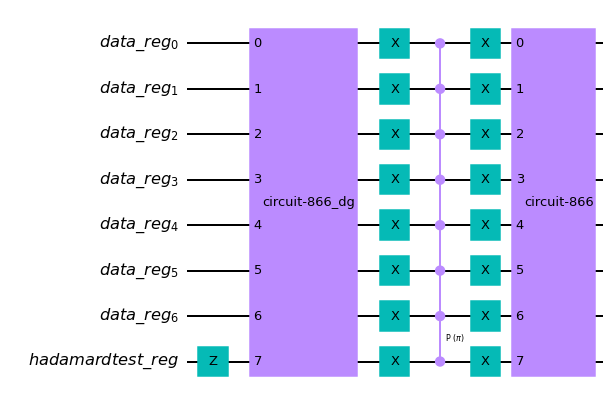

In [12]:
G_circ.draw("mpl")

In [13]:
st1 = Statevector.from_instruction(G_circ)
print("ST1:")
disp_subsyst_statevector(st1,[G_circ.num_qubits-1])

ST1:
When remaining qubits are in states |0000000>  (probability= 0.3398579685057013 ),
the statevector of qubits 7 is
[0.548+0.j    0.832+0.085j]
When remaining qubits are in states |0000001>,|0000100>,|0000101>,|0001100>,|0001101>,|0010000>,|0010001>,|0010100>,|0010101>,|0100000>,|0100001>,|0100100>,|0100101>,|0101100>,|0101101>,|1000000>,|1000001>,|1000100>,|1000101>,|1001100>,|1001101>,|1010000>,|1010001>,|1100000>,|1100001>,|1100100>,|1100101>,|1101100>,|1101101>  (probability= 0.6494948200172428 ),
the statevector of qubits 7 is
[0.707+0.j 0.707+0.j]


In [ ]:
GGate=G_circ.to_gate()
CGGate=GGate.control(1)

# Apply phase estimation on G with the initial state |Psi>

qc.h(phase_reg)
qc.append(PsiPrepGate, list(data_reg)+list(hadamardtest_reg))

for i in range(len(phase_reg)):
    for j in range(2**i):
        qc.append(CGGate, [phase_reg[i]]+list(data_reg)+list(hadamardtest_reg))

qft_dagger(qc, len(phase_reg))
#return qc

In [ ]:
qc.draw('mpl')


In [ ]:
st1 = Statevector.from_instruction(GGate)
print("ST1:")
disp_subsyst_statevector(st1,[0,1])